In [2]:
library(psych)#melt
library(vegan)#Mantel
library(tidyverse)
library(DescTools)#FisherZ

library(reshape)
library(ggplot2)

In [27]:
LOOCV_sig = function(ind_dir){
    rsa = c()
    sub = c()
    p_value = c()
    num = 6 # depend on files
    for (one_dir in ind_dir){
        # get the one left
        dissim_one = read.csv(one_dir,row.names = 1)
        sub = append(sub,strsplit(strsplit(one_dir,'/')[[1]][num],'.csv')[[1]][1])

        # remove one subjects from all subjects
        dissim_left_one = data.frame(matrix(rep(0,159*159),nrow=159,ncol=159))
        ind_dir_left_one = ind_dir #after copy, the following revision didn't change raw data
        ind_dir_left_one = ind_dir_left_one[-which(ind_dir_left_one == one_dir)]
        for (left_one_dir in ind_dir_left_one){
            dissim_temp = read.csv(left_one_dir,row.names = 1)
            dissim_left_one = dissim_left_one + dissim_temp
        }
        dissim_left_one_avg = dissim_left_one/length(ind_dir_left_one) 
        # caculate the correlation between the one and others
        # significance test is a permutation test.
        rsa = append(rsa, mantel(dissim_one,dissim_left_one_avg,method = 'spearman')$statistic)
        p_value = append(p_value,mantel(dissim_one,dissim_left_one_avg,method = 'spearman')$signif)
    }
    data_quality_df = data.frame(rsa,sub,p_value)
    data_quality_df$'FDR' = p.adjust(data_quality_df$p_value,method = "fdr")
    data_quality_df$'Bonferroni' = p.adjust(data_quality_df$p_value,method = "bonferroni")
    
    return(data_quality_df)
}

# LOOCV: 159 relationships & 60 participants

In [28]:
imp_ind_list = list.files('../output_data/individual/category/Subject_MA_RDMs_revised/', pattern = "*.csv")
imp_ind_dir = c()
for (ind in imp_ind_list){
  imp_ind_dir = append(imp_ind_dir,paste('../output_data/individual/category/Subject_MA_RDMs_revised/',ind, sep = ''))
}

exp_ind_list = list.files('../output_data/individual/category/Subject_Category_RDMs_revised/', pattern = "*.csv")
exp_ind_dir = c()
for (ind in exp_ind_list){
  exp_ind_dir = append(exp_ind_dir,paste('../output_data/individual/category/Subject_Category_RDMs_revised/',ind, sep = ''))
}

In [29]:
exp_159r_60p_LOOCV = LOOCV_sig(exp_ind_dir)
imp_159r_60p_LOOCV = LOOCV_sig(imp_ind_dir)

In [30]:
write.csv(exp_159r_60p_LOOCV,file = '../output_data/outlier_check/exp_159r_60p_LOOCV.csv')
write.csv(imp_159r_60p_LOOCV,file = '../output_data/outlier_check/imp_159r_60p_LOOCV.csv')

# Outliers list

Input results directly

In [32]:
exp_159r_60p_LOOCV = read.csv('../output_data/outlier_check/exp_159r_60p_LOOCV.csv',row.names=1)
imp_159r_60p_LOOCV = read.csv('../output_data/outlier_check/imp_159r_60p_LOOCV.csv',row.names=1)

In [33]:
sum(exp_159r_60p_LOOCV$sub == imp_159r_60p_LOOCV$sub)

[1] 60

In [35]:
exp_imp_r_value = data.frame(cbind(exp_159r_60p_LOOCV$sub,exp_159r_60p_LOOCV$rsa,imp_159r_60p_LOOCV$rsa))
colnames(exp_imp_r_value) = c('sub','exp','imp')
write.csv(exp_imp_r_value,file='../output_data/outlier_check/r_value_exp_imp.csv')

exp_imp_r_value_melt = melt(exp_imp_r_value,id.vars = 'sub')
colnames(exp_imp_r_value_melt) = c('sub','task','loocv_r')
exp_imp_r_value_melt$loocv_r = as.numeric(exp_imp_r_value_melt$loocv_r)

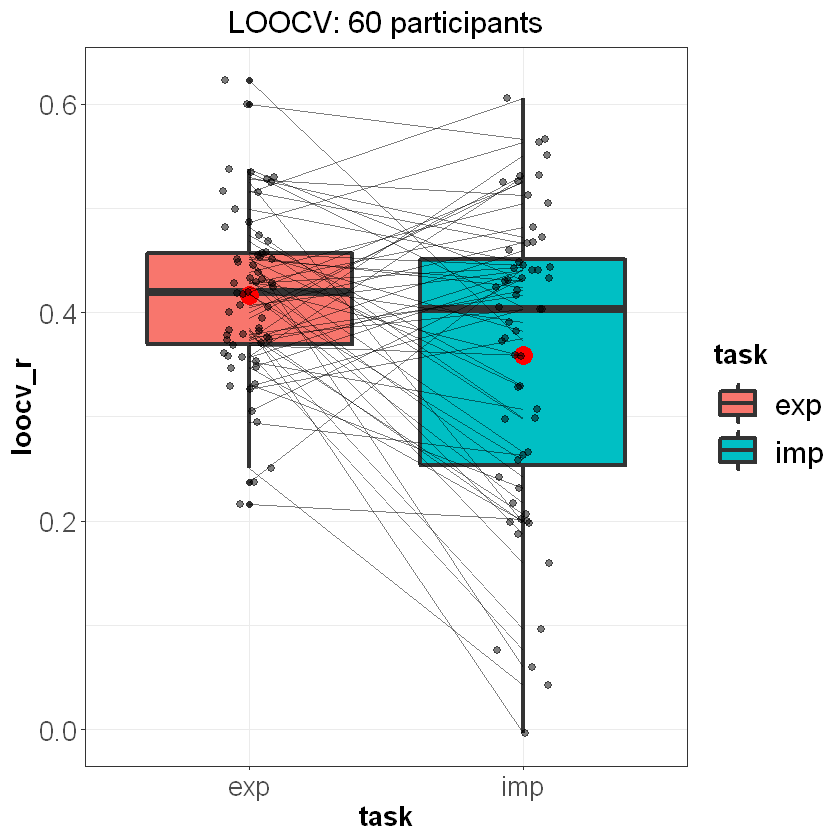

In [37]:
ggplot(exp_imp_r_value_melt,aes(x=task,y=loocv_r))+
geom_boxplot(aes(fill=task),lwd=1.25)+
stat_summary(fun = mean, geom = "point", shape = 16, size=5,color='red')+
geom_jitter(color="black", size=2,alpha=0.5,
            position = position_jitter(0.1))+
geom_line(aes(group = sub),alpha=0.5,size=0.5) +

ggtitle('LOOCV: 60 participants')+
theme_bw()+
theme(axis.title.x = element_text(size=16,face='bold'),
      axis.title.y = element_text(size=16,face='bold'),
      axis.text = element_text(size=16),
      legend.key.size = unit(1,"cm"),
      legend.title = element_text(size=16,face='bold'),
      legend.text = element_text(size=18),
      plot.title = element_text(hjust = 0.5,size=18))

In [42]:
exp_159r_60p_LOOCV %>% filter(FDR>0.05)
imp_159r_60p_LOOCV %>% filter(FDR>0.05)

rsa,sub,p_value,FDR,Bonferroni
<dbl>,<chr>,<dbl>,<dbl>,<dbl>


rsa,sub,p_value,FDR,Bonferroni
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-0.003611427,sub-692,0.579,0.579,1


There was no significant correlation between the "sub-692" and the left average results of the participants. Consequently, we viewed "sub-692" as an outlier and remove this participant from the following analysis.

# Turn Matrix into average RDM

In [1]:
import pandas as pd
import glob
import numpy as np

In [2]:
#filter target subjects    
def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]

In [5]:
input_dir = '../output_data/individual/'
#All subjects
#Explicit Categorization
ca_subj_data_paths_all = []
for file in glob.glob(input_dir + 'category/Subject_Category_RDMs_revised/*.csv'):
    ca_subj_data_paths_all.append(file)

#Implicit Categorization
ma_subj_data_paths_all = []
for file in glob.glob(input_dir + 'category/Subject_MA_RDMs_revised/*.csv'):
    ma_subj_data_paths_all.append(file)

In [6]:
# remove poor participants
sub_60p_list = [i.split('\\')[1].split('.')[0] for i in ca_subj_data_paths_all]
print(f'There were {len(sub_60p_list)} participants in total.')

poor_list = ['sub-692']
sub_59p_list = [subj for subj in sub_60p_list if subj not in poor_list]
print(f'There were {len(sub_59p_list)} participants in total after exclusion.')

There were 60 participants in total.
There were 59 participants in total after exclusion.


In [8]:
#participants who finished dimension rating
sub_file = glob.glob(input_dir + 'dimension/clean_results/dim_rel/*') 
sub_list = [i.split('\\')[1].split('.')[0] for i in sub_file]
sub_list = [i.replace('soc','sub') for i in sub_list]
print('Found participants who finished dimension rating task: '+str(len(sub_list))+' participants.')

Found participants who finished dimension rating task: 14 participants.


all 59 participants

In [9]:
#Explicit task
ca_59p_data_paths = Filter(ca_subj_data_paths_all, sub_59p_list)
print('Explicit task:From {} subjects filter {} subjects.'.format(len(ca_subj_data_paths_all),len(ca_59p_data_paths)))

temp_df = pd.read_csv(ca_59p_data_paths[0], index_col=0)
dissim_ctg_avg = np.zeros(temp_df.shape)

for f in ca_59p_data_paths:
    temp_df = pd.read_csv(f, index_col=0)
    dissim_ctg_avg += np.array(temp_df)
    
dissim_ctg_avg = dissim_ctg_avg / len(ca_59p_data_paths)
dissim_ctg_avg = pd.DataFrame(dissim_ctg_avg, index=temp_df.index, columns=temp_df.columns)
dissim_ctg_avg_159 = dissim_ctg_avg
dissim_ctg_avg_159.to_csv('../output_data/group/category/dissim_ctg_avg_159rel_all_59p.csv')

#Implicit task
ma_59p_data_paths = Filter(ma_subj_data_paths_all, sub_59p_list)
print('Implicit task:From {} subjects filter {} subjects.'.format(len(ma_subj_data_paths_all),len(sub_59p_list)))

temp_df = pd.read_csv(ma_59p_data_paths[0], index_col=0)
dissim_mla_avg = np.zeros(temp_df.shape)

for f in ma_59p_data_paths:
    temp_df = pd.read_csv(f, index_col=0)
    dissim_mla_avg += np.array(temp_df)
    
dissim_mla_avg = dissim_mla_avg / len(ma_59p_data_paths)
dissim_mla_avg = pd.DataFrame(dissim_mla_avg, index=temp_df.index, columns=temp_df.columns)
dissim_mla_avg_159 = dissim_mla_avg

dissim_mla_avg_159.to_csv('../output_data/group/category/dissim_mla_avg_159rel_all_59p.csv')

Explicit task:From 60 subjects filter 59 subjects.
Implicit task:From 60 subjects filter 59 subjects.
